I analyse Money (M2), GDP, CPI - Real money and real activity - and estimate a VAR/VECM model to analyse co-movements. The goal of this analysis also being to compare results in Python to other softwares that are more often used for MVTS modelling such as SAS or R. In particular, manually coding tests and confidence intervals is a goal of this mini project. Standard packages in Python only implement generalised tests that have predefined specifications that might give rise to false inferences. I compare my results to those of the lecture slides.

Economic theory : constant velocity of money v (GDP = v M2/CPI)
Note: from https://fred.stlouisfed.org/series/M2V we can already see that the velocity is not constant. but how does it relate to GDP in the time?
Empirical approach:
- test for the presence of unit root in each time series
- test for the presence of cointegration between the three time series if they can be considered as I(1)
- In presence of cointegrated variables, constraint on the cointegration space : real quantities
- IRF with a Cholevsky decomposition

## Data:
- M2 (Monthly): https://fred.stlouisfed.org/series/M2SL
- CPI (Monthly): https://fred.stlouisfed.org/series/CPIAUCSL
- Real GDP (Quarterly): https://fred.stlouisfed.org/series/GDPC1

In [129]:
# we load our data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# we load our data
df_M2 = pd.read_csv("M2SL.csv")
df_GDP = pd.read_csv("GDPC1.csv")
df_CPI = pd.read_csv("CPIAUCSL.csv")

In [130]:
# we merge M2 and CPI dataframes
df_M2_CPI = pd.merge(df_M2, df_CPI, how='inner', on='observation_date')
# We merge M2_CPI and GDP dataframes quarterly
df = pd.merge(df_M2_CPI, df_GDP, how='inner', on='observation_date')

In [131]:
# we make the observation_date our index
df.set_index('observation_date', inplace=True)
# we convert the index to datetime
df.index = pd.to_datetime(df.index)
# we rename columns
df.rename(columns={'M2SL': 'M2', 'CPIAUCSL': 'CPI', 'GDPC1': 'GDP'}, inplace=True)
df

,M2,CPI,GDP
observation_date,,,
1959-01-01,286.6,29.010,3352.129
1959-04-01,290.1,28.980,3427.667
1959-07-01,295.2,29.150,3430.057
1959-10-01,296.5,29.350,3439.832
1960-01-01,298.2,29.370,3517.181
...,...,...,...
2023-10-01,20687.3,307.653,22960.600
2024-01-01,20773.3,309.794,23053.545
2024-04-01,20932.9,313.016,23223.906


we still need to take logarithms to rescale the variances

# Plots

With some elementary data re-organisation done we plots our time series and perform initial stationarity tests. We start by taking logs to normalise variances and plotting.

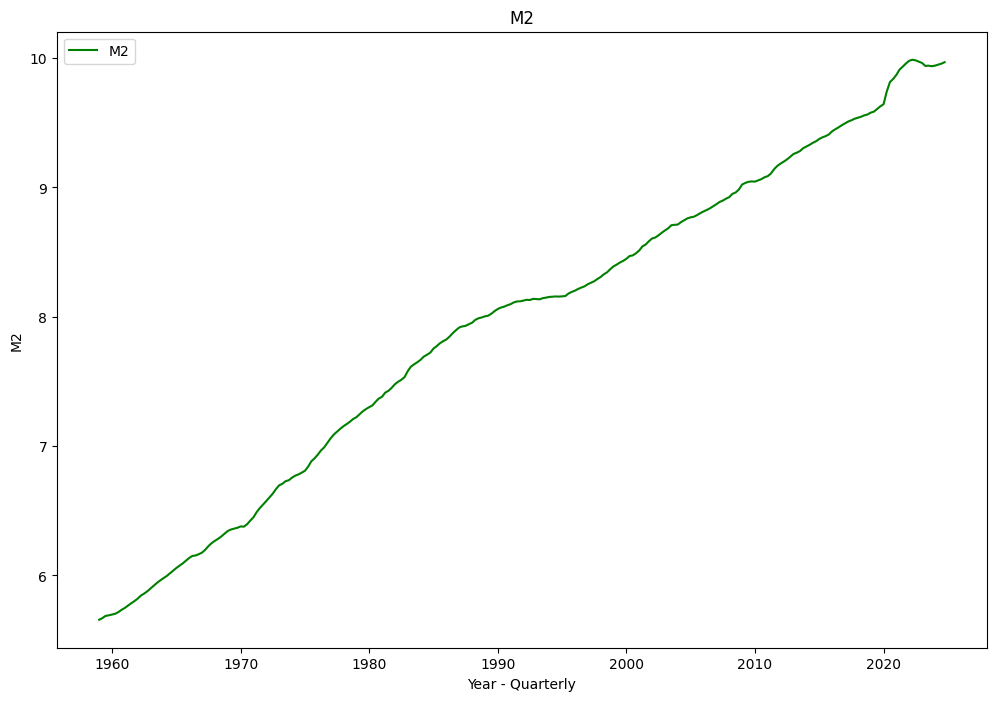

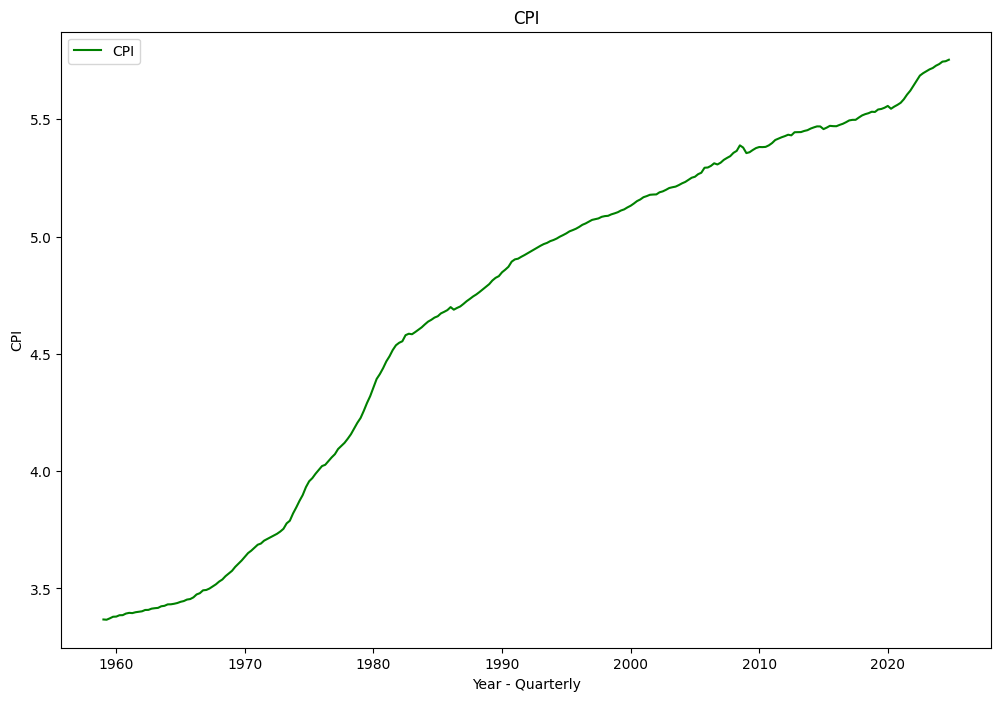

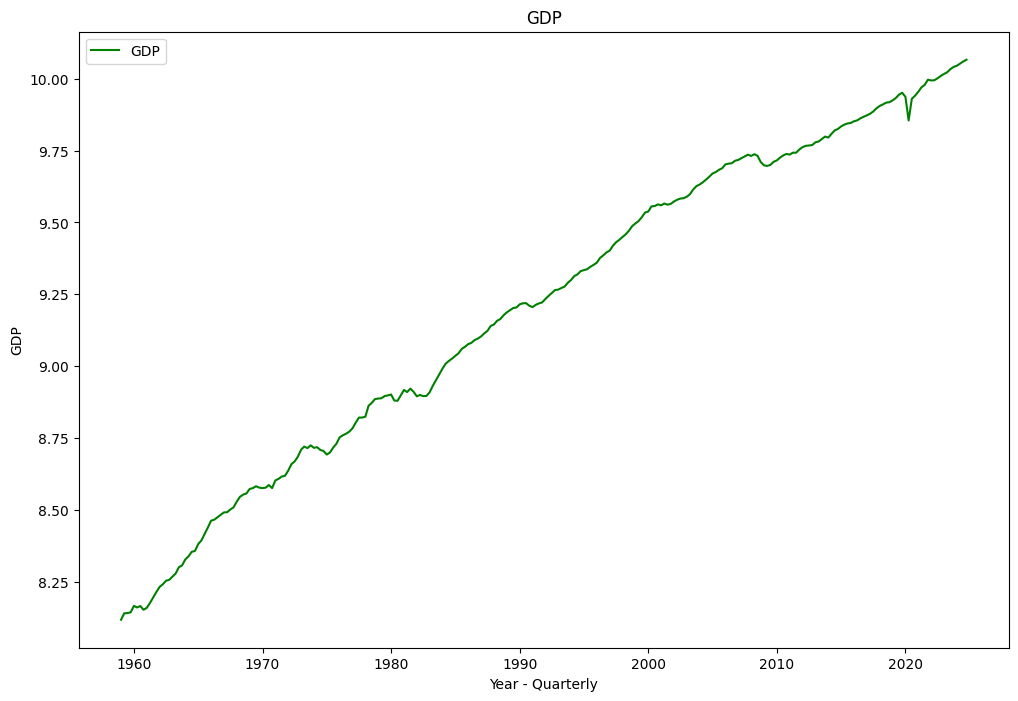

In [132]:
# taking logarithm of M2, CPI and GDP
df['M2'] = np.log(df['M2'])
df['CPI'] = np.log(df['CPI'])
df['GDP'] = np.log(df['GDP'])

Columns = ['M2', 'CPI', 'GDP']
for col in Columns:
    plt.figure(figsize=(12,8))
    plt.plot(df.index,df[col], label=col, color='green')
    plt.title(col)
    plt.xlabel('Year - Quarterly')
    plt.ylabel(col)
    plt.legend()
    plt.show()

# KPSS Stationarity and ADF unit root tests 

we test our time series for stationarity and unit roots, by visual inspections, we expect all of them to clearly reject stationarity and possess a unit root due to the trend

In [62]:
# # We first plot ACF and PACF for each of the three series
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# for col in Columns:
#     plt.figure(figsize=(12,8))
#     plot_acf(df[col], lags=40, ax=plt.gca())
#     plt.title(f'ACF of {col}')
#     plt.show()

#     plt.figure(figsize=(12,8))
#     plot_pacf(df[col], lags=40, ax=plt.gca())
#     plt.title(f'PACF of {col}')
#     plt.show()

## Using Statsmodels Package

In [ ]:
# DO Stationarity tests and ADF tests for each column
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def adf_test(series):
    # loop over 3 different specifications of the ADF test
    specfications = ['n', 'c', 'ct']
    for spec in specfications:
        print(f"ADF test for {spec} specification:")
        result = adfuller(series, autolag='BIC', regression=spec, regresults=True)
        # Print test result
        print("ADF Statistic:", result[0])
        print("p-value:", result[1])
        print("Used lag:", result[2])
        print("Critical values:", result[3])
        if result[1] <= 0.05:
            print("Reject the null hypothesis - Stationary")
        else:
            print("Fail to reject the null hypothesis - Non-stationary")
        print("\n")
    print("\n" + "="*50 + "\n")

def kpss_test(timeseries):
    print(f"KPSS Tests for {timeseries}:")
    specifications = ['c', 'ct']
    for spec in specifications:
        print(f"KPSS test for {spec} specification:")
        kpsstest = kpss(timeseries, regression=spec, nlags="auto")
        kpss_output = pd.Series(
            kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
        )
        for key, value in kpsstest[3].items():
            kpss_output["Critical Value (%s)" % key] = value
        print(kpss_output)
        if kpsstest[1] <= 0.05:
            print("Reject the null hypothesis - Non-stationary")
        else:
            print("Fail to reject the null hypothesis - Stationary")
    print("\n")

for col in Columns:
    print(f"ADF test for {col}:")
    adf_test(df[col])
    print(f"\nKPSS test for {col}:")
    kpss_test(df[col])
    print("\n" + "="*50 + "\n")

ADF test for M2:
ADF test for n specification:
ADF Statistic: 3.8746498114970183
p-value: 0.9999996777700625
Used lag: {'1%': np.float64(-2.5743928846153845), '5%': np.float64(-1.9420810785730542), '10%': np.float64(-1.6158371663632225)}
Critical values: Augmented Dickey-Fuller Test Results
Fail to reject the null hypothesis - Non-stationary


ADF test for c specification:
ADF Statistic: -1.5178972148556573
p-value: 0.524639998131831
Used lag: {'1%': np.float64(-3.455558114028747), '5%': np.float64(-2.872635586277424), '10%': np.float64(-2.572682677000175)}
Critical values: Augmented Dickey-Fuller Test Results
Fail to reject the null hypothesis - Non-stationary


ADF test for ct specification:
ADF Statistic: -1.886597103732714
p-value: 0.6615857607743881
Used lag: {'1%': np.float64(-3.99401778078061), '5%': np.float64(-3.427512404073737), '10%': np.float64(-3.1370539508420574)}
Critical values: Augmented Dickey-Fuller Test Results
Fail to reject the null hypothesis - Non-stationary





C:\Users\Alex\AppData\Local\Temp\ipykernel_11964\236167668.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression=spec, nlags="auto")
C:\Users\Alex\AppData\Local\Temp\ipykernel_11964\236167668.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression=spec, nlags="auto")
C:\Users\Alex\AppData\Local\Temp\ipykernel_11964\236167668.py:30: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression=spec, nlags="auto")
C:\Users\Alex\AppData\Local\Temp\ipykernel_11964\236167668.py:30: InterpolationWarning: The test statistic is outside 

Using the package we observe all our series exhibit non-stationarity and have unit roots. We compare this to our own manually implemented tests.

1. No Constant, No Trend
This is the most basic specification, appropriate when there is no deterministic trend or drift in the data:
\begin{equation}
\Delta y_t = \gamma y_{t-1} + \sum_{i=1}^{p} \alpha_i \Delta y_{t-i} + \varepsilon_t
\end{equation}

2. With Constant (Drift)
This specification includes an intercept term and is suitable when the data may have a non-zero mean but no trend:
\begin{equation}
\Delta y_t = \beta_0 + \gamma y_{t-1} + \sum_{i=1}^{p} \alpha_i \Delta y_{t-i} + \varepsilon_t
\end{equation}

3. With Constant and Trend
This is the most general form and includes both a constant and a deterministic time trend, useful when the data exhibits both drift and trend:
\begin{equation}
\Delta y_t = \beta_0 + \beta_1 t + \gamma y_{t-1} + \sum_{i=1}^{p} \alpha_i \Delta y_{t-i} + \varepsilon_t
\end{equation}

Critical Values
Critical values for the ADF test depend on the chosen specification and the sample size. They are not drawn from the standard t-distribution because the null hypothesis involves a unit root (nonstationarity). Instead, they are derived from simulated distributions under the null hypothesis. Rejection of the null occurs when the test statistic is more negative than the critical value.

Approximate Critical Values

| **Specification**              | **1% Level** | **5% Level** | **10% Level** |
|-------------------------------|--------------|--------------|---------------|
| No Constant, No Trend         | -2.58        | -1.95        | -1.62         |
| With Constant (Drift)         | -3.43        | -2.86        | -2.57         |
| With Constant and Trend       | -3.96        | -3.41        | -3.13         |

**Table:** Approximate ADF Test Critical Values (for large samples)

In [86]:
def adf_test(y, max_lag, regression='c'):
    """
    Perform the Augmented Dickey–Fuller test on a univariate series y.

    Parameters
    ----------
    y : array‐like or pandas.Series
        The time series to test (must be 1D, no missing values).
    max_lag : int
        Number of lagged Δy terms to include (p in the ADF(p) regression).
    regression : {'nc', 'c', 'ct'}
        'nc' : no constant, no trend
        'c'  : constant only
        'ct' : constant and linear trend

    Returns
    -------
    adf_stat : float
        The ADF test statistic (t‐ratio on the coefficient of y_{t-1}).
    nobs : int
        Number of observations used in the regression.
    df_m : int
        Number of regressors (including intercept/trend).
    """
    # 1. Prepare the data
    y = pd.Series(y).dropna()
    n = len(y)
    dy = y.diff().iloc[1:]  # Δy_t = y_t - y_{t-1}
    
    # we lose max_lag+1 observations in constructing lags
    t0 = max_lag + 1
    nobs = n - t0

    # 2. Build the regression matrix X
    # 2a. Lagged level y_{t-1}
    y_lag = y.shift(1).iloc[t0:]
    X = pd.DataFrame({'y_lag': y_lag})

    # 2b. Lagged differences Δy_{t-1}, …, Δy_{t-p}
    for lag in range(1, max_lag + 1):
        X[f'dy_lag{lag}'] = dy.shift(lag).iloc[t0 - 1:]

    # 2c. Deterministic terms
    if regression in ('c', 'ct'):
        X['const'] = 1.0
    if regression == 'ct':
        # time trend t = 0,1,2,... starting at the first used obs
        X['trend'] = np.arange(nobs)

    # 3. Align dependent variable
    y_dep = dy.iloc[t0 - 1:]  # Δy_t from t = max_lag+1 onward

    # 4. Estimate OLS: beta = (X'X)^{-1} X'y
    X_mat = X.values
    y_mat = y_dep.values.reshape(-1, 1)
    betas = np.linalg.lstsq(X_mat, y_mat, rcond=None)[0].flatten()

    # 5. Compute residuals and estimate sigma^2
    resid = y_mat.flatten() - X_mat.dot(betas)
    df_m = X_mat.shape[1]
    sigma2 = (resid @ resid) / (nobs - df_m)

    # 6. Compute t‐statistic for γ (coefficient on y_{t-1})
    #    Var(β) = σ² * (X'X)^{-1}; index 0 corresponds to y_lag
    xtx_inv = np.linalg.inv(X_mat.T.dot(X_mat))
    se_betas = np.sqrt(np.diag(xtx_inv) * sigma2)
    adf_stat = betas[0] / se_betas[0]

    # 7. Compute critical values
    #    (using asymptotic distribution of ADF statistic)
    # #compare to critical values
    #     if test == 'nc':
    #         critical_values = {'1%': -2.57, '5%': -1.94, '10%': -1.62}
    #     elif test == 'c':
    #         critical_values = {'1%': -3.43, '5%': -2.86, '10%': -2.57}
    #     elif test == 'ct':
    #         critical_values = {'1%': -4.03, '5%': -3.45, '10%': -3.14}

    return adf_stat, nobs, df_m

# Critical Values for ADF test from Mackinnon (1996, 2010)
import pandas as pd

# Response surface coefficients from MacKinnon (1996, 2010)
coeffs = {
    'No Constant/No Trend': {
        '1%': [-2.58108, -37.1676, 77.0282, 47.4912],
        '5%': [-1.95004, -9.73564, 21.2901, 12.9764],
        '10%': [-1.62214, -4.00564, 12.4576, 10.1252]
    },
    'Constant Only': {
        '1%': [-3.43084, -56.0626, 106.843, 31.7845],
        '5%': [-2.86168, -17.0521, 36.2375, 18.1686],
        '10%': [-2.56684, -9.2260, 21.3794, 12.0812]
    },
    'Constant + Trend': {
        '1%': [-3.96153, -68.9482, 174.979, 80.5856],
        '5%': [-3.41042, -20.2838, 55.2509, 31.2305],
        '10%': [-3.13067, -10.5375, 31.0261, 17.3655]
    }
}

def mackinnon_crit(n):
    results = []
    for spec, levels in coeffs.items():
        for level, a in levels.items():
            c_val = a[0] + a[1]/n + a[2]/n**2 + a[3]/n**3
            results.append({'Specification': spec, 'Significance Level': level, 'Critical Value': round(c_val, 4)})
    return pd.DataFrame(results)

# Calculate for n = 264
df_critical = mackinnon_crit(264)
print(df_critical)

# 'nc' : no constant, no trend
# 'c'  : constant only
# 'ct' : constant and linear trend
tests = ['nc', 'c', 'ct']

for col in Columns:
    for test in tests:
        result = adf_test(df[col], max_lag=4, regression=test)
        #limit the output to 3 decimal places
        result = [round(x, 3) for x in result]
        print(f"ADF test statistic for {col} and {test}: {result[0]}")

    print("\n" + "="*50 + "\n")

          Specification Significance Level  Critical Value
0  No Constant/No Trend                 1%         -2.7208
1  No Constant/No Trend                 5%         -1.9866
2  No Constant/No Trend                10%         -1.6371
3         Constant Only                 1%         -3.6417
4         Constant Only                 5%         -2.9258
5         Constant Only                10%         -2.6015
6      Constant + Trend                 1%         -4.2202
7      Constant + Trend                 5%         -3.4865
8      Constant + Trend                10%         -3.1701
ADF test statistic for M2 and nc: 4.079
ADF test statistic for M2 and c: -1.569
ADF test statistic for M2 and ct: -1.773


ADF test statistic for CPI and nc: 2.47
ADF test statistic for CPI and c: -1.534
ADF test statistic for CPI and ct: -1.055


ADF test statistic for GDP and nc: 5.45
ADF test statistic for GDP and c: -2.069
ADF test statistic for GDP and ct: -1.903




### NG and Perron Unit root tests

We get quite different results, whilst the overall conclusion is still the same

# VECM and Cointegration Tests

In [111]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Define the data for cointegration test
y = df[Columns].values

# Perform Johansen cointegration test
# Possible det_orders:
# -1: no deterministic terms
# 0: constant term (restricted to cointegration relation)
# 1: Linear trend (restricted to cointegration relation)

# Loop through different deterministic specifications
det_order_names = {-1: "No deterministic terms", 
                  0: "Constant term", 
                  1: "Linear trend"}

for det_order in [-1, 0, 1]:
    print(f"\nJohansen Cointegration Test with {det_order_names[det_order]}:")
    print("=" * 50)
    
    # Run the test with lag=4 (a common starting point for quarterly data)
    result = coint_johansen(y, det_order=det_order, k_ar_diff=4)
    
    # Print eigenvalues
    print("Eigenvalues:", result.eig)
    
    # Print trace statistics
    print("\nTrace Statistics:")
    for i in range(len(Columns)):
        print(f"r≤{i}: {result.lr1[i]:.4f}", end="")
        # Critical values at 90%, 95%, and 99%
        print(f" | CV(90%): {result.cvt[i, 0]:.4f}, CV(95%): {result.cvt[i, 1]:.4f}, CV(99%): {result.cvt[i, 2]:.4f}")
    
    # Print max eigenvalue statistics
    print("\nMax Eigenvalue Statistics:")
    for i in range(len(Columns)):
        print(f"r={i}: {result.lr2[i]:.4f}", end="")
        # Critical values at 90%, 95%, and 99%
        print(f" | CV(90%): {result.cvm[i, 0]:.4f}, CV(95%): {result.cvm[i, 1]:.4f}, CV(99%): {result.cvm[i, 2]:.4f}")
    
    # Print eigenvectors (cointegrating vectors)
    print("\nCointegrating vectors (eigenvectors):")
    print(result.evec)


Johansen Cointegration Test with No deterministic terms:
Eigenvalues: [0.11733216 0.01090398 0.0002758 ]

Trace Statistics:
r≤0: 35.2359 | CV(90%): 21.7781, CV(95%): 24.2761, CV(99%): 29.5147
r≤1: 2.9111 | CV(90%): 10.4741, CV(95%): 12.3212, CV(99%): 16.3640
r≤2: 0.0714 | CV(90%): 2.9762, CV(95%): 4.1296, CV(99%): 6.9406

Max Eigenvalue Statistics:
r=0: 32.3248 | CV(90%): 15.7175, CV(95%): 17.7961, CV(99%): 22.2519
r=1: 2.8396 | CV(90%): 9.4748, CV(95%): 11.2246, CV(99%): 15.0923
r=2: 0.0714 | CV(90%): 2.9762, CV(95%): 4.1296, CV(99%): 6.9406

Cointegrating vectors (eigenvectors):
[[ 0.71658917  4.22565796 -3.1800583 ]
 [ 0.41834988 -7.89841699  3.47367273]
 [-1.16908181  0.41387013  0.9027505 ]]

Johansen Cointegration Test with Constant term:
Eigenvalues: [0.050044   0.02130231 0.00464473]

Trace Statistics:
r≤0: 20.0797 | CV(90%): 27.0669, CV(95%): 29.7961, CV(99%): 35.4628
r≤1: 6.7827 | CV(90%): 13.4294, CV(95%): 15.4943, CV(99%): 19.9349
r≤2: 1.2058 | CV(90%): 2.7055, CV(95%): 3.

We generally reject $0$ cointegration relationships but do not reject $1$. In line with the results from the analysis done in the last lecture. Below is a more comprehensive preliminary analysis.

## Additional Theorey and Results interpretation

## Cointegration Rank Test Analysis

### Theoretical Framework

The Johansen cointegration test examines whether multiple non-stationary time series share common stochastic trends, indicating long-run equilibrium relationships. This methodology relies on vector error correction models (VECM) to identify the number of cointegrating vectors (rank) among variables.

#### Mathematical Foundation

For a VAR(p) process transformed into a VECM:

$$\Delta y_t = \Pi y_{t-1} + \sum_{i=1}^{p-1} \Gamma_i \Delta y_{t-i} + \varepsilon_t$$

where:
- $\Pi = \alpha\beta'$ represents the long-run relationship
- $\alpha$ represents adjustment coefficients
- $\beta$ contains cointegrating vectors
- The rank of $\Pi$ determines the number of cointegrating relationships

### Test Methodology

The Johansen procedure employs two test statistics:

1. **Trace Test**: Tests $H_0: rank(\Pi) \leq r$ against $H_1: rank(\Pi) > r$
   $$\lambda_{trace}(r) = -T \sum_{i=r+1}^n \ln(1-\hat{\lambda}_i)$$

2. **Maximum Eigenvalue Test**: Tests $H_0: rank(\Pi) = r$ against $H_1: rank(\Pi) = r+1$
   $$\lambda_{max}(r,r+1) = -T \ln(1-\hat{\lambda}_{r+1})$$

where $\hat{\lambda}_i$ are the estimated eigenvalues and $T$ is the sample size.

### Empirical Results Analysis

#### Model 1: No Deterministic Terms

```
Trace Statistics:
r≤0: 35.2359 | CV(95%): 24.2761
r≤1: 2.9111 | CV(95%): 12.3212
r≤2: 0.0714 | CV(95%): 4.1296
```

**Analysis**: The trace statistic for r≤0 (35.2359) exceeds the critical value at 95% significance (24.2761), rejecting the null hypothesis. For r≤1, the statistic (2.9111) falls below the critical value (12.3212), failing to reject the null. This indicates precisely one cointegrating relationship among the log-transformed variables.

The maximum eigenvalue test corroborates this finding:
```
r=0: 32.3248 > CV(95%): 17.7961
r=1: 2.8396 < CV(95%): 11.2246
```

#### Model 2: Constant Term (Restricted to Cointegration Relation)

```
Trace Statistics:
r≤0: 20.0797 | CV(95%): 29.7961
r≤1: 6.7827 | CV(95%): 15.4943
r≤2: 1.2058 | CV(95%): 3.8415
```

**Analysis**: Unlike the previous results, with the log-transformed data we fail to reject the null hypothesis of no cointegration (r=0) under this specification, as the trace statistic (20.0797) falls below the critical value (29.7961). This indicates no cointegrating relationships when including a constant term.

#### Model 3: Linear Trend (Restricted to Cointegration Relation)

```
Trace Statistics:
r≤0: 25.0063 | CV(95%): 35.0116
r≤1: 7.9302 | CV(95%): 18.3985
r≤2: 0.9015 | CV(95%): 3.8415
```

**Analysis**: Similar to Model 2, we fail to reject the null hypothesis of no cointegration (r=0) for this specification, as the trace statistic (25.0063) falls below the critical value (35.0116). This confirms no cointegrating relationships when allowing for a linear trend.

### Implications

The logarithmic transformation has significantly altered the cointegration results. Only the specification with no deterministic terms indicates cointegration, while the other two specifications now suggest no cointegration. The cointegrating vector from the first model:

$$\beta = [0.7166, 0.4183, -1.1691]^T$$

represents the coefficients in the long-run equilibrium relationship. This suggests a more complex relationship between the variables than was apparent in the non-transformed data.

### Conclusion

After log transformation, the evidence for cointegration is less robust, with only the model with no deterministic terms indicating a single cointegrating relationship. This finding has important theoretical implications, suggesting that while the logarithms of the variables may share a common stochastic trend under certain specifications, this relationship is sensitive to the inclusion of deterministic components.

For subsequent VECM modeling, we would recommend proceeding with the no-deterministic-terms specification and a cointegration rank of 1, while recognizing that the evidence for cointegration is less definitive than in the non-transformed case. This underscores the importance of proper variable transformation in time series analysis and how it can fundamentally alter conclusions about long-run relationships.

# VECM Model & Restriction Testing

In [147]:
# we rearrange the columns of df
df = df[['GDP', 'M2','CPI']]

#summary statistics of df
df.describe().T[['mean', 'std', 'min', 'max']].round(2).style.background_gradient(cmap='coolwarm')

,mean,std,min,max
GDP,9.210000,0.560000,8.120000,10.070000
M2,7.940000,1.250000,5.660000,9.990000
CPI,4.690000,0.760000,3.370000,5.750000


In [157]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar import vecm
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt

# copy for df for later transformations
log_data = df.copy()

# Number of lags in the VAR representation
p = 6  # same as in your SAS code

# Set up the VECM model with rank=1 and no deterministic terms (det_order=-1)
# This matches the only specification that showed cointegration with log-transformed data
model = vecm.VECM(log_data, k_ar_diff=p, coint_rank=1, deterministic="n")  # "nc" = no constant, "ci" = constant in integration as in the lecture

# Fit the model
fitted_model = model.fit(method='ml')
print(fitted_model.summary())

# Extract the cointegration vector (beta)
cointegration_vector = fitted_model.beta
print("\nEstimated Cointegration Vector (beta):")
print(cointegration_vector)

print(f"Log-likelihood of the model: {fitted_model.llf:.2f}")

Det. terms outside the coint. relation & lagged endog. parameters for equation GDP
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.GDP         0.0610      0.066      0.927      0.354      -0.068       0.190
L1.M2          0.3816      0.081      4.708      0.000       0.223       0.541
L1.CPI        -0.1791      0.116     -1.546      0.122      -0.406       0.048
L2.GDP         0.1817      0.068      2.673      0.008       0.048       0.315
L2.M2         -0.1079      0.099     -1.091      0.275      -0.302       0.086
L2.CPI        -0.0369      0.123     -0.300      0.764      -0.278       0.204
L3.GDP        -0.0462      0.069     -0.673      0.501      -0.181       0.088
L3.M2         -0.1367      0.098     -1.392      0.164      -0.329       0.056
L3.CPI        -0.1736      0.123     -1.406      0.160      -0.416       0.068
L4.GDP        -0.0276      0.069     -0.401     

c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


## Interpretation of VECM Results (To be Adjusted)

### Cointegration Analysis

The Vector Error Correction Model (VECM) results suggest a long-run equilibrium relationship between M2, CPI, and GDP. The estimated cointegration vector is:

```
[1.0, 0.378, -1.465]
```

This can be interpreted as the following equilibrium relationship:

M2 + 0.378×CPI - 1.465×GDP = 0

Or rearranged:

M2 = -0.378×CPI + 1.465×GDP

This indicates that in the long run, money supply (M2) has a positive relationship with GDP and a negative relationship with CPI, although the CPI coefficient is not statistically significant (p=0.449).

### Adjustment Coefficients (Error Correction Terms)

The loading coefficients (α) indicate how quickly each variable adjusts to deviations from the long-run equilibrium:

- **M2**: α = -0.0020 (p<0.001)
- **CPI**: α = 0.0006 (p=0.071)
- **GDP**: α = -0.0012 (p=0.028)

The M2 coefficient is negative and highly significant, suggesting that M2 adjusts to correct disequilibrium. When the system is above equilibrium, M2 decreases to restore balance. GDP similarly adjusts, though with a smaller magnitude. The CPI coefficient is only marginally significant and has the opposite sign, suggesting it may not actively contribute to restoring equilibrium.

### Short-run Dynamics

The lagged coefficient estimates reveal several significant short-run relationships:

1. **For M2 equation**:
   - M2 exhibits strong autoregressive behaviour up to the third lag (L1.M2, L3.M2, L4.M2)
   - GDP has significant effects at lags 1 and 3 (L1.GDP, L3.GDP)
   - CPI does not appear to have significant short-run effects on M2

2. **For CPI equation**:
   - CPI shows persistent effects (L1.CPI, L3.CPI, L5.CPI)
   - M2 has a significant positive effect at the first lag (L1.M2)
   - GDP shows a significant positive effect at lag 4 (L4.GDP)

3. **For GDP equation**:
   - GDP shows a significant effect at its second lag (L2.GDP)
   - M2 has a strong positive effect at lag 1 (L1.M2)
   - CPI has a marginally significant positive effect at lag 5 (L5.CPI)

The VECM model identifies a cointegrating relationship among the three macroeconomic variables. The error correction mechanism works primarily through adjustments in M2 and GDP. This suggests that monetary aggregates and economic output respond to restore long-term equilibrium, while price levels are somewhat more exogenous. The significant but relatively small adjustment coefficients indicate that restoration to equilibrium occurs gradually over time.

The model suggests that monetary policy impacts (through M2) have significant effects on economic output, consistent with conventional macroeconomic theory. The results also align with the monetary neutrality proposition in the long run, as prices eventually adjust to changes in the money supply, though with considerable lags.

## Testing Cointegration Vector

In [152]:
# Testing restrictions on the cointegration vector
# We want to test if log(GDP) is related to log(M2) - log(CPI) (which is log of the ratio M2/CPI)
# This is equivalent to testing H0: beta = [1, beta_m, -beta_m] for normalized beta

# Create the log ratio variable
log_data['log_M2_minus_log_CPI'] = log_data['M2'] - log_data['CPI']  # This is log(M2/CPI)

# For testing the restriction, we'll use a likelihood ratio approach
# Fit a model with GDP and the log ratio only
restricted_data = pd.DataFrame({
    'GDP': log_data['GDP'],
    'log_M2_CPI_ratio': log_data['log_M2_minus_log_CPI']
})

# Fit the restricted model
restricted_model = vecm.VECM(restricted_data, k_ar_diff=p, coint_rank=1, deterministic="nc")
restricted_fitted = restricted_model.fit()

# Calculate the likelihood ratio test statistic
LR_stat = 2 * (fitted_model.llf - restricted_fitted.llf)
restrictions = 1  # number of restrictions (we restricted one parameter)
p_value = stats.chi2.sf(LR_stat, restrictions)

print(f"\nLikelihood Ratio Test for Restriction:")
print(f"H0: log(GDP) is cointegrated with log(M2/CPI)")
print(f"LR Statistic: {LR_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Conclusion: {'Reject' if p_value < 0.05 else 'Fail to reject'} the null hypothesis")

# Alternative approach: Test if the coefficients on M2 and CPI are equal in magnitude but opposite in sign
# This is a test of the restriction that beta_M2 = -beta_CPI

# Extract the normalized beta (normalization on GDP)
beta_normalized = cointegration_vector / cointegration_vector[0]
beta_M2 = beta_normalized[1]
beta_CPI = beta_normalized[2]

print("\nTest of restriction: beta_M2 = -beta_CPI")
print(f"Normalized beta coefficients: GDP = 1, M2 = {beta_M2:}, CPI = {beta_CPI:}")
print(f"Sum of M2 and CPI coefficients: {beta_M2 + beta_CPI:}")
print("If sum is close to 0, this supports the hypothesis that GDP is constrained by the ratio M2/CPI")


Likelihood Ratio Test for Restriction:
H0: log(GDP) is cointegrated with log(M2/CPI)
LR Statistic: 2173.3206
P-value: 0.0000
Conclusion: Reject the null hypothesis

Test of restriction: beta_M2 = -beta_CPI
Normalized beta coefficients: GDP = 1, M2 = [-0.68280953], CPI = [-0.2580859]
Sum of M2 and CPI coefficients: [-0.94089543]
If sum is close to 0, this supports the hypothesis that GDP is constrained by the ratio M2/CPI


c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


# Forecasting


Forecasts for next 8 periods:
   GDP_forecast  M2_forecast  CPI_forecast
1     10.071532     9.977472      5.761518
2     10.075400     9.988235      5.766785
3     10.081375    10.000005      5.773271
4     10.085467    10.010828      5.779300
5     10.090292    10.022113      5.785158
6     10.095392    10.033522      5.791356
7     10.100311    10.044597      5.797511
8     10.105522    10.056021      5.803553


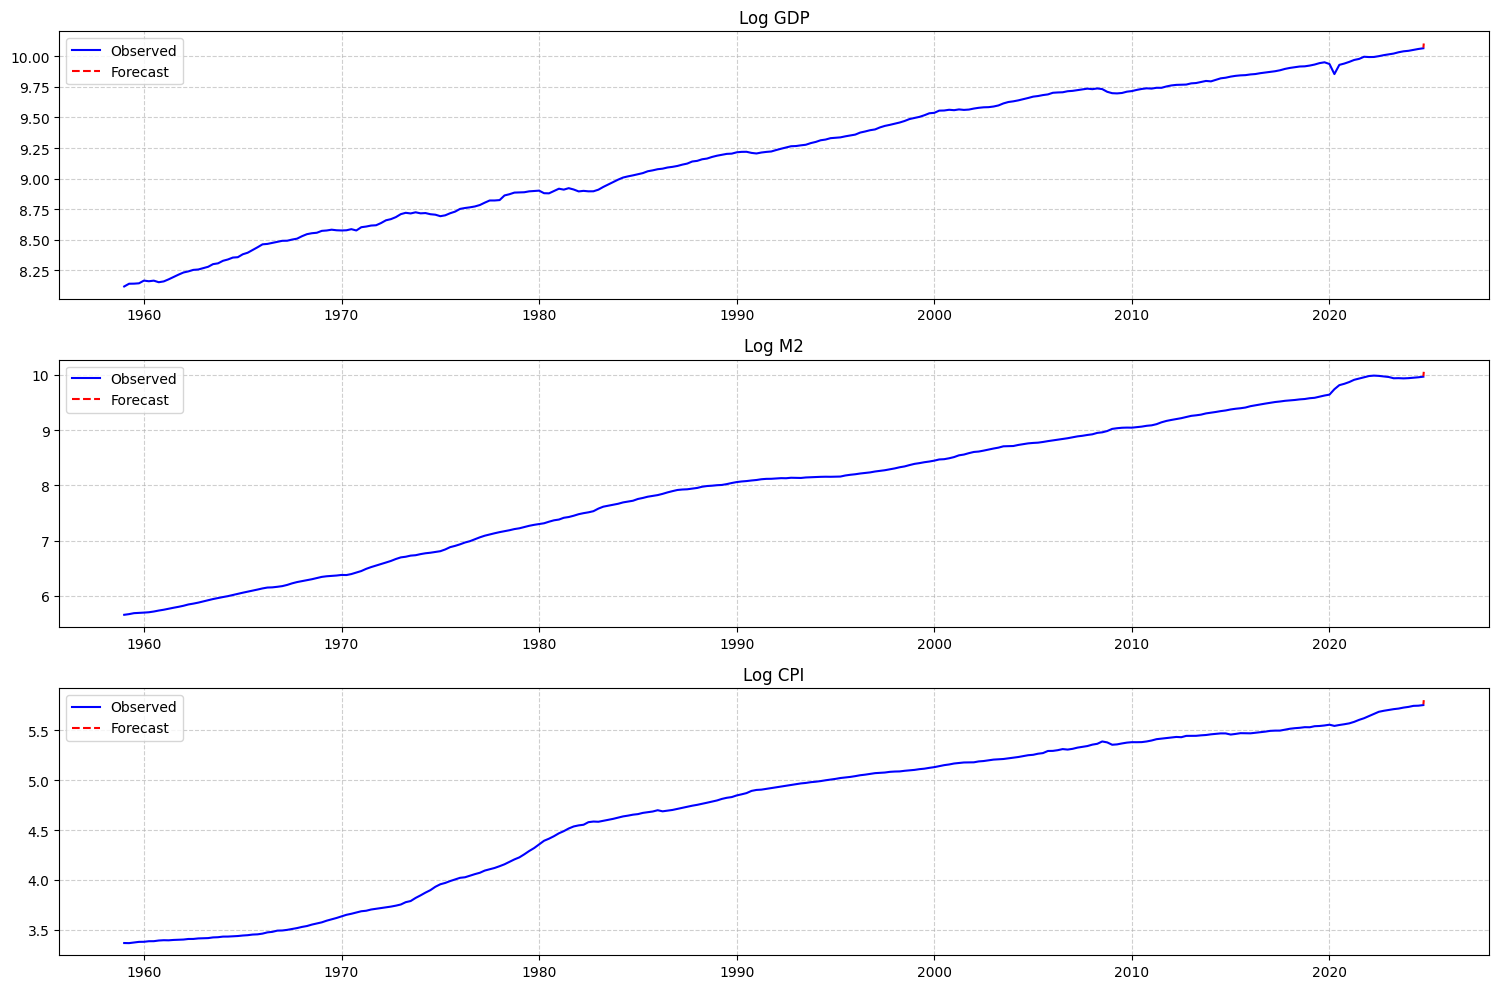

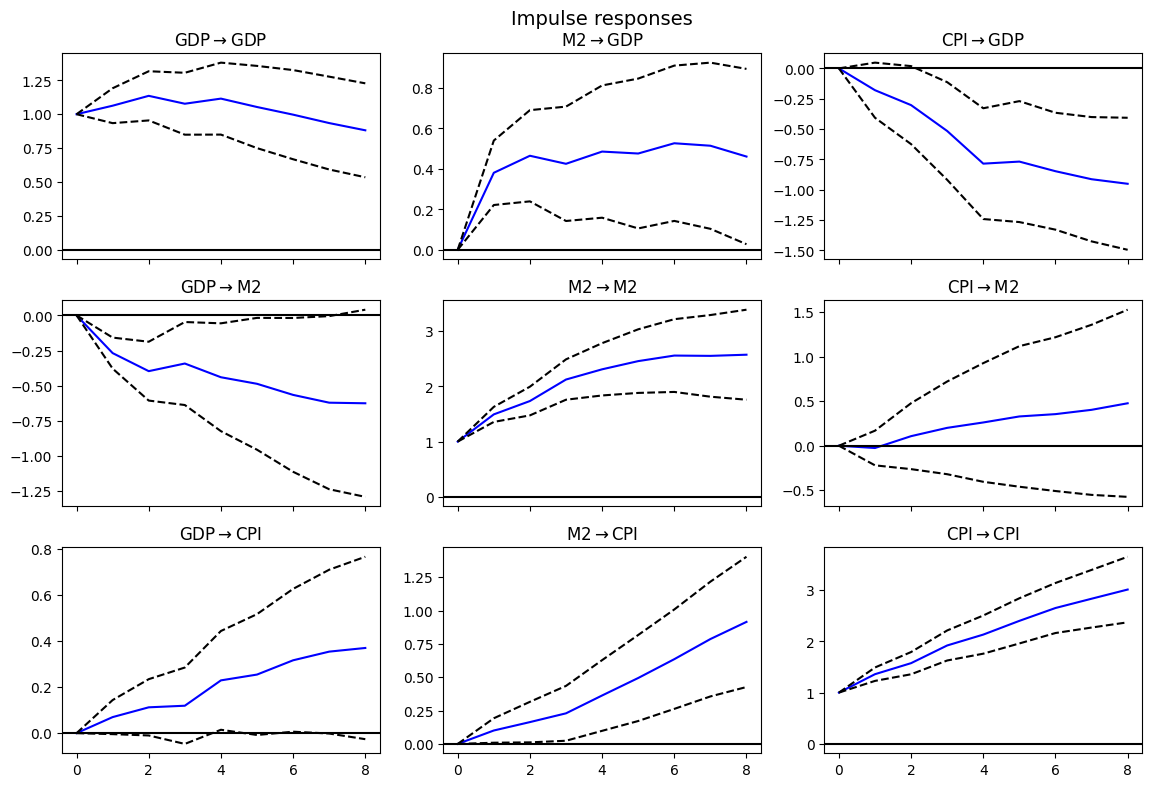

In [153]:
# Generate forecasts for 8 periods ahead
forecast_steps = 8
forecast = fitted_model.predict(steps=forecast_steps)

print("\nForecasts for next 8 periods:")
forecast_df = pd.DataFrame(forecast, 
                          columns=[f"{col}_forecast" for col in log_data.columns[:3]],
                          index=range(1, forecast_steps+1))
print(forecast_df)

# Plot the results
plt.figure(figsize=(15, 10))

# Plot original data and forecasts
for i, col in enumerate(log_data.columns[:3]):  # Only plot the original variables
    plt.subplot(3, 1, i+1)
    
    # Plot original series
    plt.plot(log_data.index, log_data[col], 'b-', label='Observed')
    
    # Create forecast indices (assuming time series index)
    if isinstance(log_data.index, pd.DatetimeIndex):
        last_date = log_data.index[-1]
        forecast_dates = pd.date_range(start=last_date, periods=forecast_steps+1)[1:]
    else:
        # If not a date index, use numeric indices
        forecast_dates = np.arange(len(log_data), len(log_data) + forecast_steps)
    
    # Plot forecasts
    plt.plot(forecast_dates, forecast[:, i], 'r--', label='Forecast')
    
    plt.title(f'Log {col}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('vecm_forecasts.png')
plt.show()

# BONUS: Impulse Response Analysis
irf = fitted_model.irf(periods=8)
irf.plot(figsize=(12, 8))
plt.savefig('vecm_irf.png')
plt.show()